<a href="https://colab.research.google.com/github/mbarbetti/unifi-physics-lab3/blob/main/Calibrazione_oscilloscopio_con_ricerca_dei_picchi_2021.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Calibrazione temporale dell'oscilloscopio con ricerca dei picchi 
===
Lo scopo di questo programma è ricavare il fattore di conversione tra la misura del TDC in **unità aribitrarie** (*a.u.*) e i nanosecondi (*ns*). In aggiunta, il valore dell'intercetta ottenuto dal fit lineare permetterà di correggere le misure dei tempi da eventuali **errori sistematici** dovuti alla catena elettronica, all'oscilloscopio o a LabVIEW. 

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [3]:
## INSERIRE NUMERO DEL GRUPPO
group = "B1"   # esempio

Sfruttiamo il file di testo (".txt") per preparare un `DataFrame` Pandas, cioè una tabella organizzata per righe e colonne avente un set di funzioni utili per cercare, modificare, aggiungere o rimuovere elementi.

In [4]:
file_path = f"https://raw.githubusercontent.com/mbarbetti/unifi-physics-lab3/main/data/2021/data_{group}.txt"
data = pd.read_csv (file_path, header = 4, delim_whitespace = True).drop([0])
data['QDC1'] = -data['QDC1'] * 1e9
data['QDC2'] = -data['QDC2'] * 1e9
data['TDC'] = data['TDC'] * 1e9
print(data)   # dataframe
print(min(data['QDC1'])," ",min(data['QDC1']))

               TDC      QDC1      QDC2
1      4174.176933  2.914583  2.956250
2      3041.472163  2.945833  2.927083
3      3228.229529  2.897916  2.927083
4      7066.190206  4.477084  4.900001
5      7013.936415  2.910416  2.918750
...            ...       ...       ...
20456  1714.462888  2.935416  2.933333
20457  1703.826175  5.510418  3.897917
20458  5499.608286  2.935416  2.970833
20459  2281.421119  2.931250  2.927083
20460  3995.408671  6.698960  3.343750

[20460 rows x 3 columns]
2.75625   2.75625


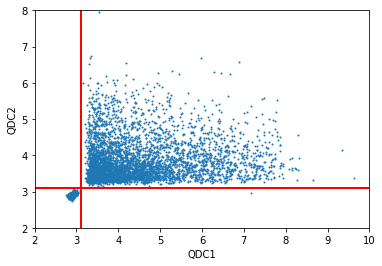

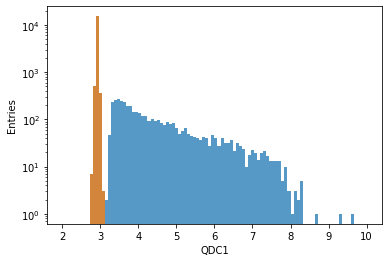

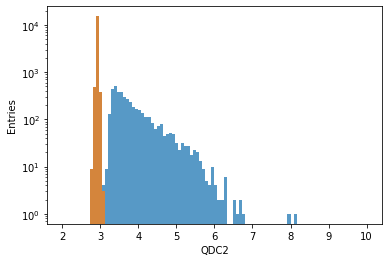

In [5]:
# Plot calib values
qdc1_max = 3.1
qdc2_max = 3.1

data_calib = data.query (f"(QDC1 < {qdc1_max}) & (QDC2 < {qdc2_max})")
qdc1 = data_calib['QDC1']
qdc2 = data_calib['QDC2']
qdc1_all = data['QDC1']
qdc2_all = data['QDC2']

plt.xlabel ("QDC1")
plt.ylabel ("QDC2")
plt.plot ([0,10], [qdc2_max, qdc2_max], color = "red", lw = 2)
plt.plot ([qdc1_max, qdc1_max], [0,10], color = "red", lw = 2)
plt.scatter (qdc1_all, qdc2_all, s=1)
plt.axis ([2,10,2,8])
plt.show()

nbin = 100

plt.xlabel ("QDC1")
plt.ylabel ("Entries")
plt.hist (qdc1_all, bins=nbin, range = (2,10), alpha = 0.75, label='QDC1')
plt.hist (qdc1, bins=nbin, range = (2,10), alpha = 0.75, label='QDC1')
plt.yscale("log")
plt.show()

plt.xlabel ("QDC2")
plt.ylabel ("Entries")
plt.hist (qdc2_all, bins=nbin, range = (2,10), alpha = 0.75, label='QDC2')
plt.hist (qdc2, bins=nbin, range = (2,10), alpha = 0.75, label='QDC2')
plt.yscale("log")
plt.show()

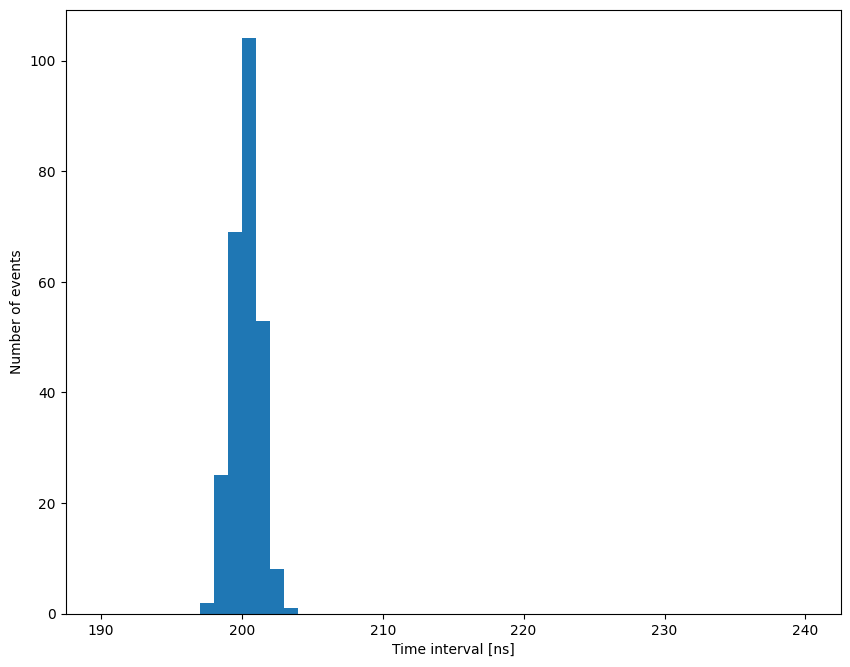

[ 0  0  0 ... 77 33  2]
[0.0000e+00 1.0000e+00 2.0000e+00 ... 1.2127e+04 1.2128e+04 1.2129e+04]


In [16]:
### Prepare and fill histogram of time intervals
tdc = data_calib["TDC"].values

tmin = 190     # tdc.min()
tmax = 240   # tdc.max()
nbins = tmax-tmin
#nbins = 500

plt.figure (figsize = (10,8), dpi = 100)
plt.xlabel('Time interval [ns]')
plt.ylabel('Number of events')
plt.hist (data_calib['TDC'], bins=nbins, range = (tmin, tmax), label='Measured time intervals')
plt.yscale("linear")
plt.show()

#prepare date for peak finder 
nbins = int(data_calib['TDC'].max() + 1)
hist = np.histogram(tdc, bins=nbins, range=[0,nbins])
print(hist[0])
print(hist[1])

I tempi di riferimento per la calibrazione sono quelli prodotti dal **TIME CALIBRATOR**  che produce segnali di _start_ e _stop_ ogni 160 ns in una finestra temporale di circa 10 $\mu$s. Disponendo i tempi misurati dall'oscilloscopio in un istogramma, quello che ci aspettiamo di osservare è un "pettine" con 64 denti corrispondente ai 64 valori dei tempi accessibili dal TIME CALIBRATOR:

<center>$\mathcal{N}_{peaks} = \frac{\rm{finestra \, temporale}}{1/\rm{frequenza}} = \frac{10240 \, \rm{ns}}{160 \, \rm{ns}} = 64$</center>

In [17]:
freq = 160   # time in ns
t_cal = np.arange (1,65) * freq
t_cal   # TIME CALIBRATOR values

array([  160,   320,   480,   640,   800,   960,  1120,  1280,  1440,
        1600,  1760,  1920,  2080,  2240,  2400,  2560,  2720,  2880,
        3040,  3200,  3360,  3520,  3680,  3840,  4000,  4160,  4320,
        4480,  4640,  4800,  4960,  5120,  5280,  5440,  5600,  5760,
        5920,  6080,  6240,  6400,  6560,  6720,  6880,  7040,  7200,
        7360,  7520,  7680,  7840,  8000,  8160,  8320,  8480,  8640,
        8800,  8960,  9120,  9280,  9440,  9600,  9760,  9920, 10080,
       10240])

La cella di codice sottostante permette di _fittare_ con una gaussiana un singolo picco contenuto nel "pettine".  
La funzione `gauss_fit` richiede i seguenti attributi:
* `sample`: un campione di misure dei tempi relativo a uno specifico picco;
* `bins`: numero di bins per costruire l'istogramma su cui fare il fit gaussiano;
* `range`: intervallo di valori scelto per l'istogramma su cui fare il fit gaussiano;
* `plot`: variabile booleana per abilitare (`True`) o meno (`False`) il plot del fit.

In [18]:
from scipy.optimize import curve_fit

def gauss (x, mean, sigma, N):
  return (N / np.sqrt (2 * np.pi * sigma**2)) * np.exp (-0.5 * (x - mean)**2 / sigma**2)

def gauss_fit (sample, bins, range, plot = False):
  weights = np.ones_like (sample) / len (sample)
  entries, bin_edges = np.histogram (sample, bins = bins, range = range, weights = weights)
  #tot_entries = np.sum (entries)
  #print (tot_entries)

  bin_centers = (bin_edges[1:] + bin_edges[:-1]) / 2.
  min_bin = bin_centers.min()
  max_bin = bin_centers.max()
  width = max_bin - min_bin

  popt, pcov = curve_fit (gauss, bin_centers, entries, bounds = ([min_bin, 0.1*width, 0.], [max_bin, width, 1.]))
  perr = np.sqrt (np.diag (pcov))

  if plot:
    plt.figure (figsize = (8,5))
    plt.title ('Fit plot', fontsize = 14)
    plt.xlabel ('ADC counts [a.u.]', fontsize = 12)
    plt.ylabel ('Normalized entries', fontsize = 12)
    plt.hist (sample, bins = bins, range = range, weights = weights, color = 'royalblue', label = 'Data')
    plt.plot (bin_centers, gauss (bin_centers, popt[0], popt[1], popt[2]), color = 'red', linewidth = 2, label = 'Fit result')
    plt.legend (loc = 'upper left', fontsize = 10)
    plt.show()

  return popt, perr

La funzione `peak_study` permette di estrarre **sotto-campioni** di tempi misurati a partire dai dati contenuti in "Dati_calibrazione.txt". Per far ciò, preso un valore di tempo _nominale_ `time_val` (multiplo di 160 ns), la cella di codice sottostante estrae un sotto-campione centrato in `time_val` e largo $2 \, \times$ `bound` dal dataset originale. Il campione così ottenuto viene quindi utilizzato per **caratterizzare** il picco. Se la _flag_ booleana `fit` è vera, allora il sotto-campione viene passato alla funzione `gauss_fit` che ne calcola centroide e deviazione standard (con relativi errori dovuti al fit). Se invece la flag booleana `fit` è falsa, allora `peak_study` ha come output la media e la deviazione standard dei valori contenuti nel sotto-campione.

In [20]:
def peak_study (sample, lower_edge, upper_edge, plot = False, fit = True):
#  mask = (sample > (time_val - bound)) & (sample < (time_val + bound))
  mask = (sample > lower_edge) & (sample < upper_edge)
  sub_sample = sample [mask]
  #print(sub_sample)

  min_val = sub_sample.min()
  max_val = sub_sample.max()
  width = max_val - min_val
  #print(min_val, max_val, width)

  bins  = 50
  _range = [min_val - 0.5 * width, max_val + 0.5 * width]

  if plot and not fit:
    print ('\n----- DATA PLOT -----')
    plt.figure (figsize = (8,5))
    plt.title  ('Time distribution', fontsize = 14)
    plt.xlabel ('Measured time', fontsize = 12)
    plt.ylabel ('Entries', fontsize = 12)
    plt.hist (sub_sample, bins = bins, range = _range, color = 'royalblue')
    plt.yscale("log")
    plt.show()

  if fit and plot:
    if plot: print ('\n----- FIT PLOT -----')
    results, errs = gauss_fit (sub_sample, bins, _range, plot = plot)
    mean, sigma, N = results
    mean_err, sigma_err, N_err = errs
  elif not fit:
    mean = np.mean (sub_sample)
    mean_err = 0.
    sigma = np.std (sub_sample)
    sigma_err = 0.

  mean_fit  = [mean, mean_err]
  sigma_fit = [sigma, sigma_err]
  return mean_fit, sigma_fit

Attivando la _flag_ booleana `plot` è possibile visualizzare il dataset preso in analisi con sovrapposta la curva gaussiana ottenuta dal fit.

In [34]:
### Algorithm for finding peaks in histogram of ADC counts
### The histogram is scanned, and an integration window is chosen around each peak to perform the gaussian fit
def findPeaks(hist, verbose=False):
    peaks = []
    RSEs = []
    starting_edge = 1
    edge = 2
    done = False

    while not done:
        integral = 0
        previous_integral = 0
        headroom = 10

        #exclude first bin

        bin_content = hist[0][edge-1]
        next_bin_content = hist[0][edge]
        previous_integral = np.sum(hist[0][starting_edge:edge-1])
        integral = np.sum(hist[0][starting_edge:edge])

        if (integral > 0 and previous_integral < 1 and starting_edge != edge -1) :
            starting_edge = edge - 1
            integral = np.sum(hist[0][starting_edge:edge])

        if (bin_content > next_bin_content  and integral > 10):
            for j in range(headroom):
                integral_temp = integral
                integral = np.sum(hist[0][starting_edge:edge+1+j])
                if (integral - integral_temp < 1) :
                    edge = edge + j 
                    break

            if (verbose):
              print("New peak found:")
              print(starting_edge)
              print(edge)
              print(integral) 

            mean, sigma = peak_study(tdc, starting_edge, edge, plot=True if verbose else False)
            weighted_avg = np.average(hist[1][starting_edge:edge], weights=hist[0][starting_edge:edge])
            peaks.append(mean[0])
            RSEs.append(mean[1])
            starting_edge = edge
        
        edge = edge +1

        if edge >= len(hist[0]) :
            done = True
        
    
    return peaks, RSEs

Inserendo la funzione `peak_study` all'interno di un ciclo `for` che corra su tutti i valori accessibili al TIME CALIBRATOR è possibile ottenere tutti i **centroidi** dei picchi che formano il "pettine".

New peak found:
197
204
262

----- FIT PLOT -----


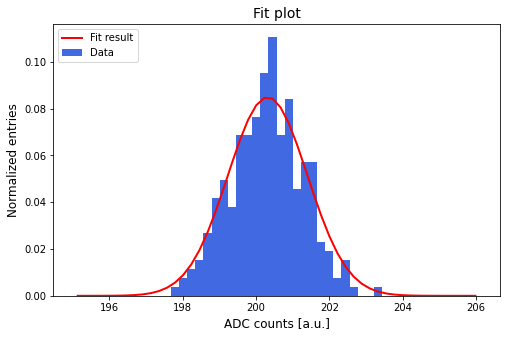

New peak found:
387
393
236

----- FIT PLOT -----


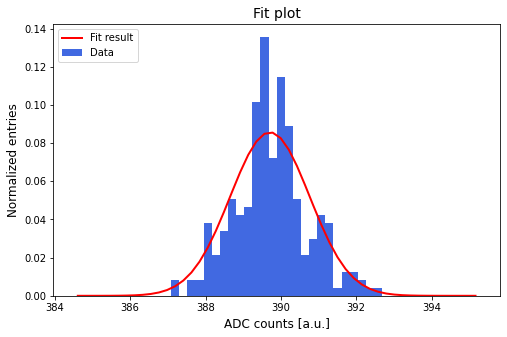

New peak found:
576
582
268

----- FIT PLOT -----


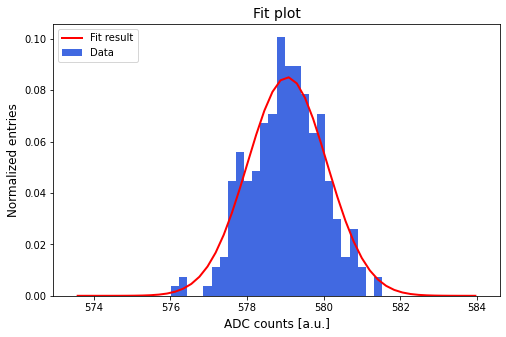

New peak found:
764
772
234

----- FIT PLOT -----


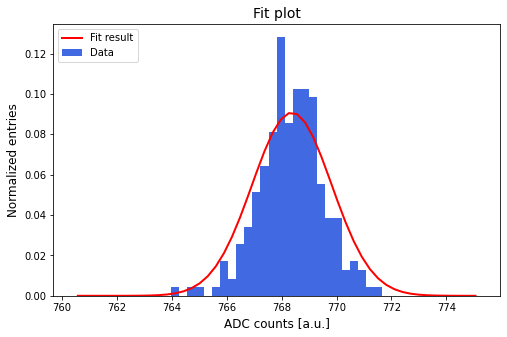

New peak found:
954
961
281

----- FIT PLOT -----


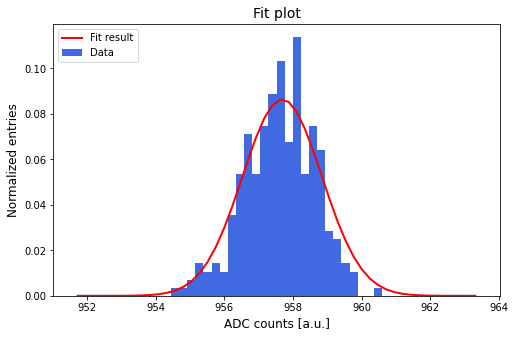

New peak found:
1144
1150
247

----- FIT PLOT -----


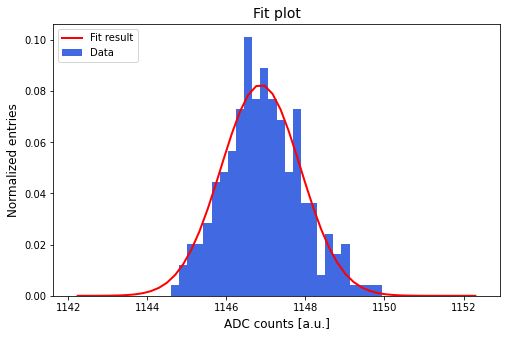

New peak found:
1333
1340
239

----- FIT PLOT -----


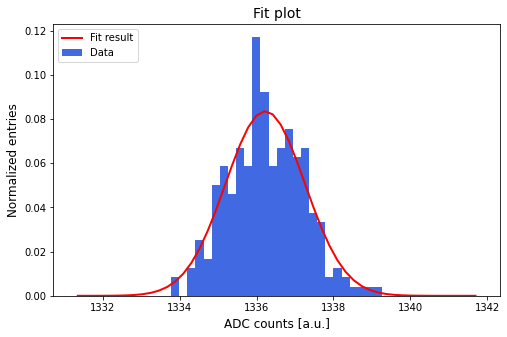

New peak found:
1521
1529
252

----- FIT PLOT -----


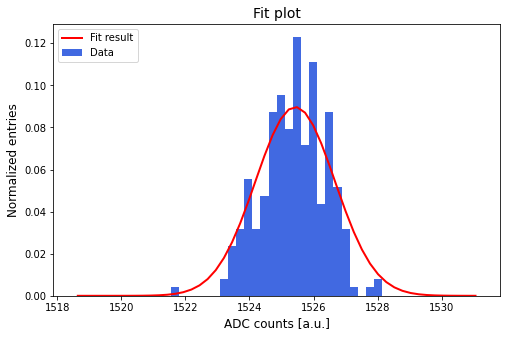

New peak found:
1712
1718
242

----- FIT PLOT -----


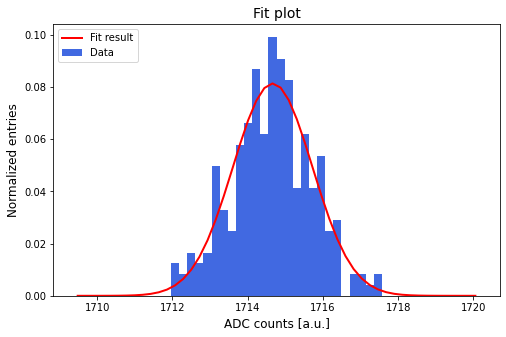

New peak found:
1901
1907
248

----- FIT PLOT -----


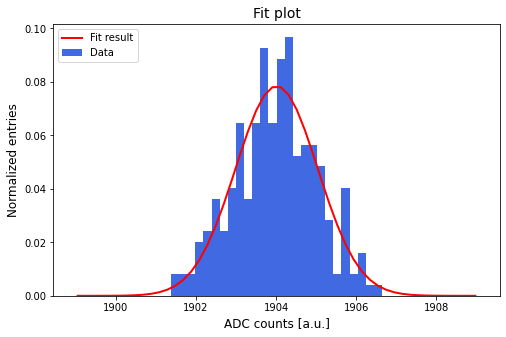

New peak found:
2090
2096
259

----- FIT PLOT -----


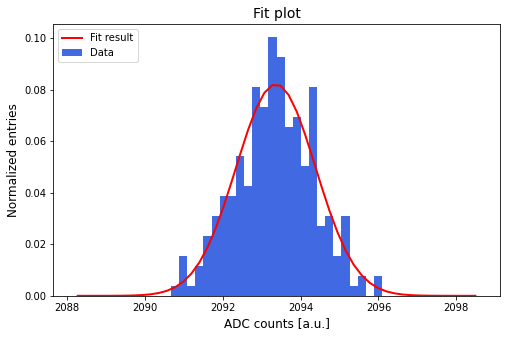

New peak found:
2279
2286
249

----- FIT PLOT -----


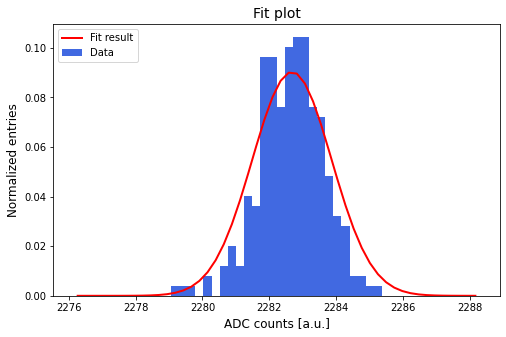

New peak found:
2468
2476
272

----- FIT PLOT -----


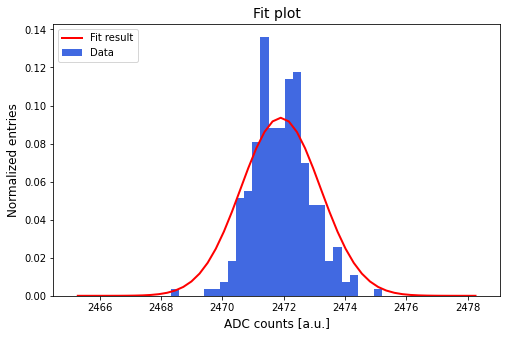

New peak found:
2658
2665
254

----- FIT PLOT -----


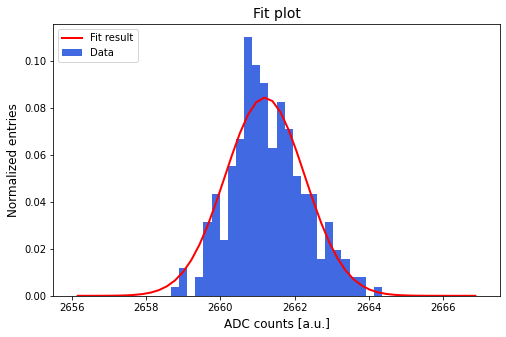

New peak found:
2847
2854
242

----- FIT PLOT -----


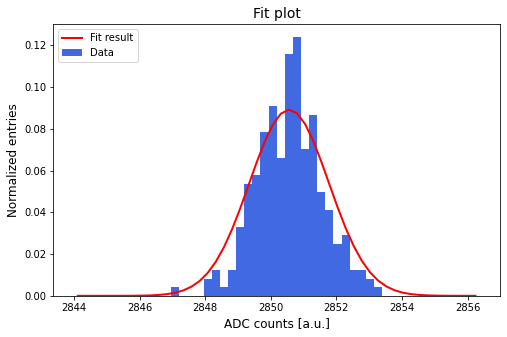

New peak found:
3037
3043
253

----- FIT PLOT -----


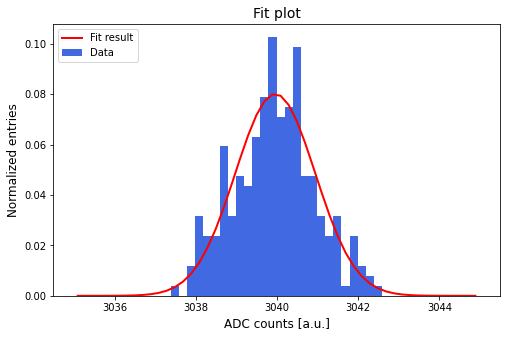

New peak found:
3226
3233
269

----- FIT PLOT -----


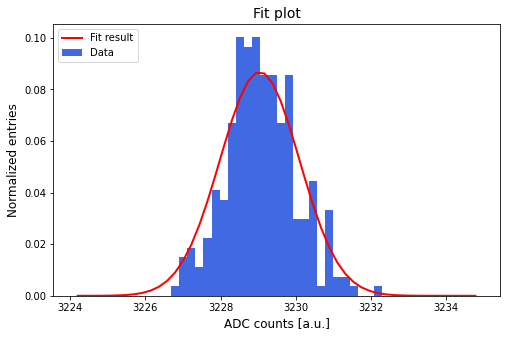

New peak found:
3416
3422
246

----- FIT PLOT -----


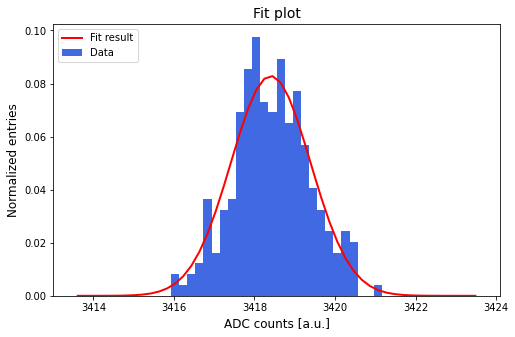

New peak found:
3603
3611
234

----- FIT PLOT -----


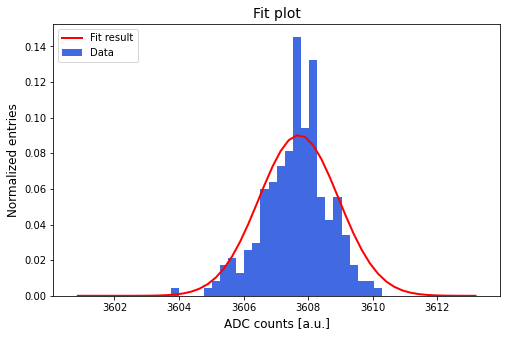

New peak found:
3794
3800
270

----- FIT PLOT -----


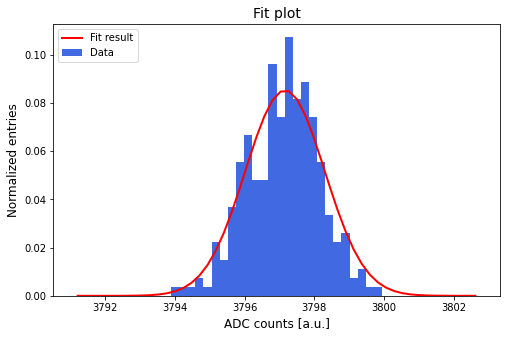

New peak found:
3983
3990
242

----- FIT PLOT -----


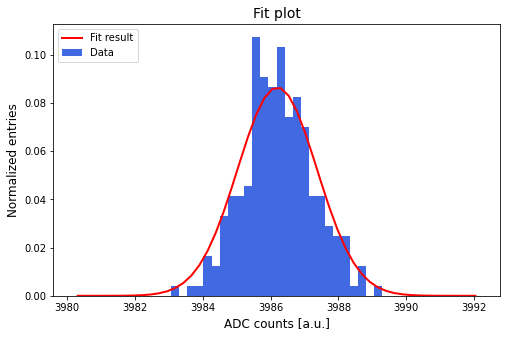

New peak found:
4173
4179
268

----- FIT PLOT -----


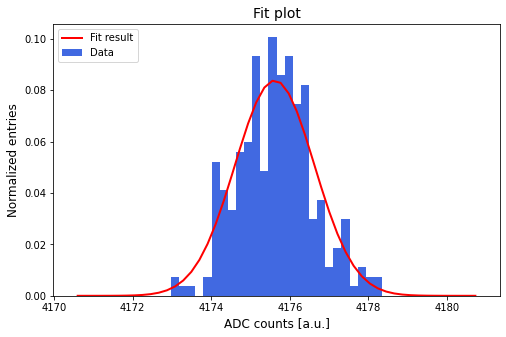

New peak found:
4362
4368
266

----- FIT PLOT -----


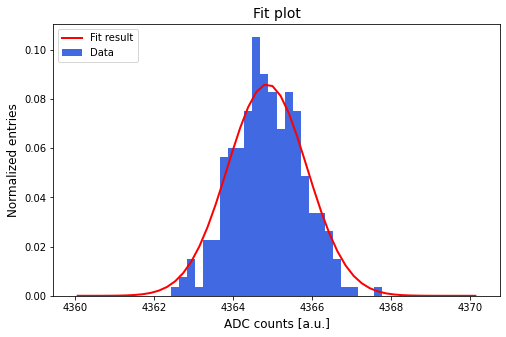

New peak found:
4551
4558
224

----- FIT PLOT -----


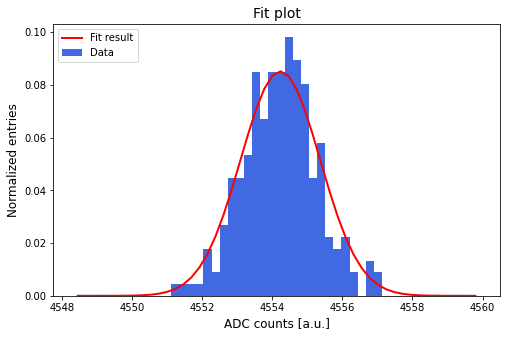

New peak found:
4740
4747
253

----- FIT PLOT -----


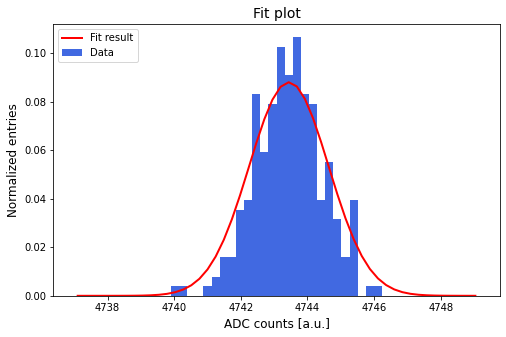

New peak found:
4930
4936
259

----- FIT PLOT -----


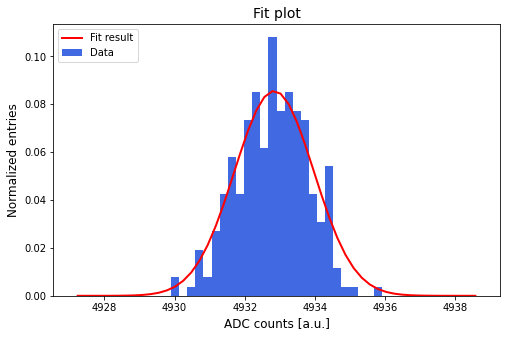

New peak found:
5118
5125
250

----- FIT PLOT -----


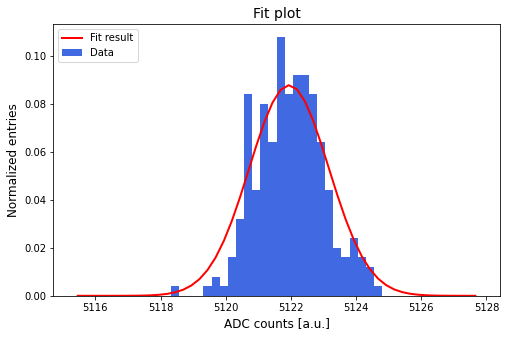

New peak found:
5308
5314
224

----- FIT PLOT -----


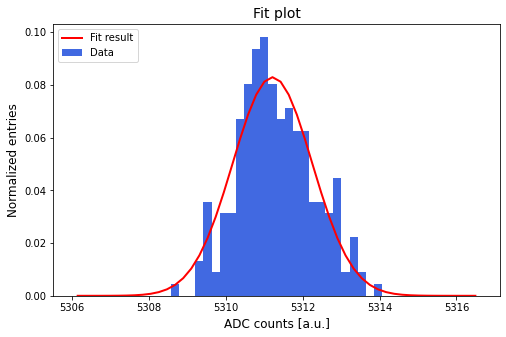

New peak found:
5497
5503
263

----- FIT PLOT -----


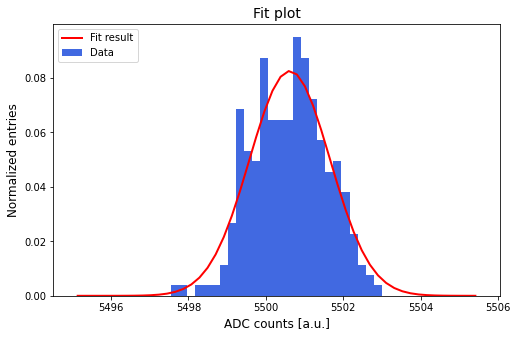

New peak found:
5686
5693
247

----- FIT PLOT -----


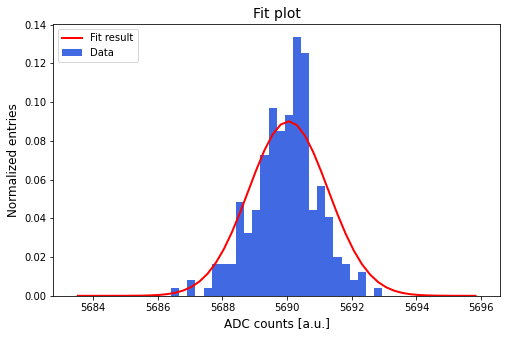

New peak found:
5876
5883
263

----- FIT PLOT -----


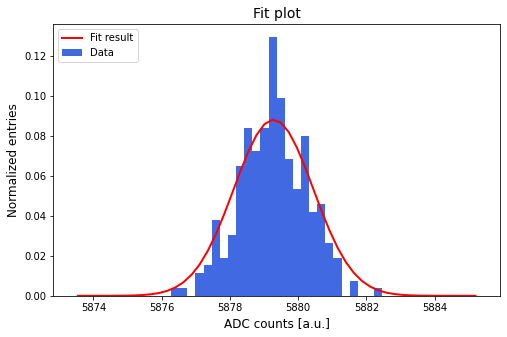

New peak found:
6065
6071
260

----- FIT PLOT -----


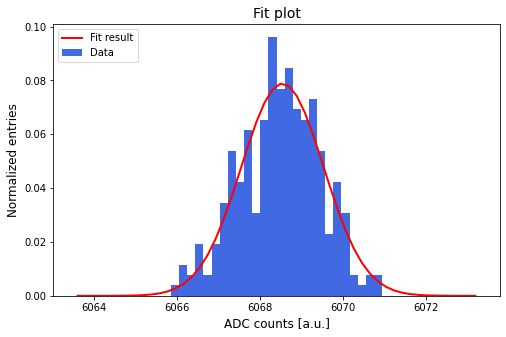

New peak found:
6255
6261
237

----- FIT PLOT -----


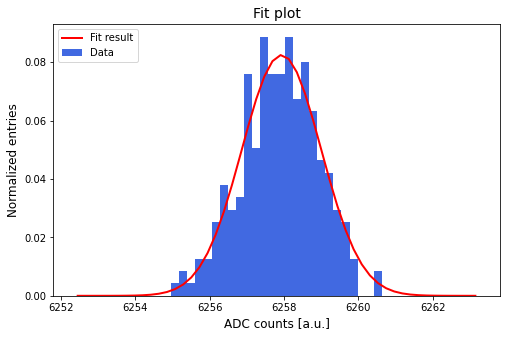

New peak found:
6444
6451
258

----- FIT PLOT -----


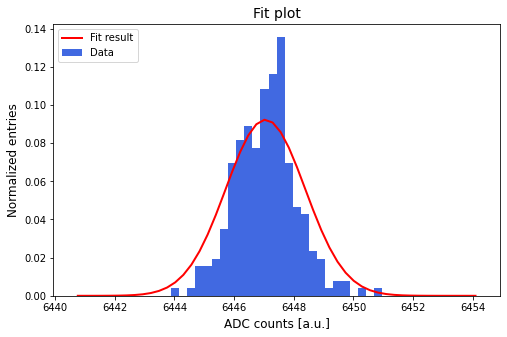

New peak found:
6633
6640
302

----- FIT PLOT -----


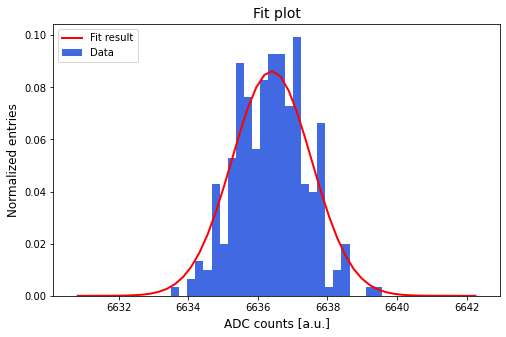

New peak found:
6822
6829
237

----- FIT PLOT -----


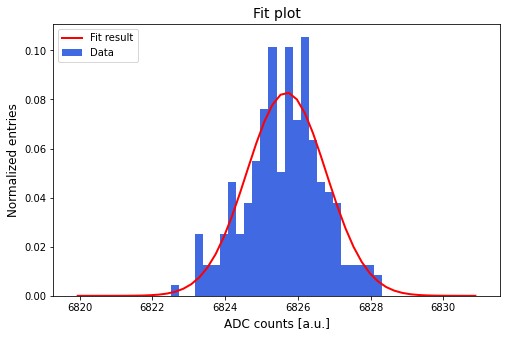

New peak found:
7012
7018
243

----- FIT PLOT -----


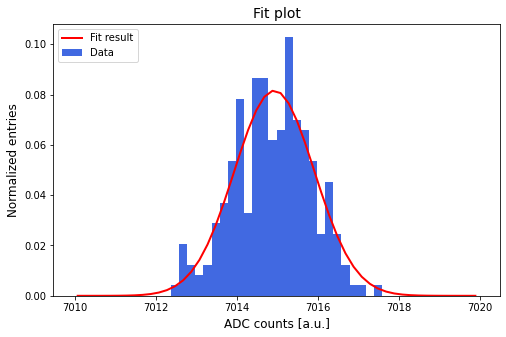

New peak found:
7201
7207
235

----- FIT PLOT -----


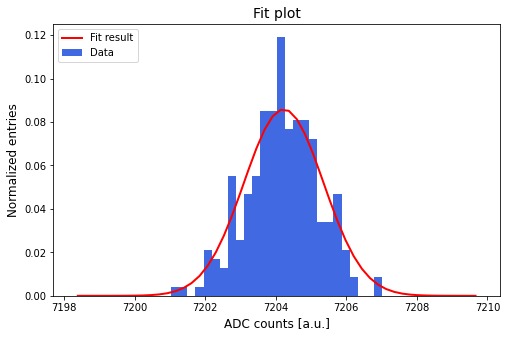

New peak found:
7390
7397
234

----- FIT PLOT -----


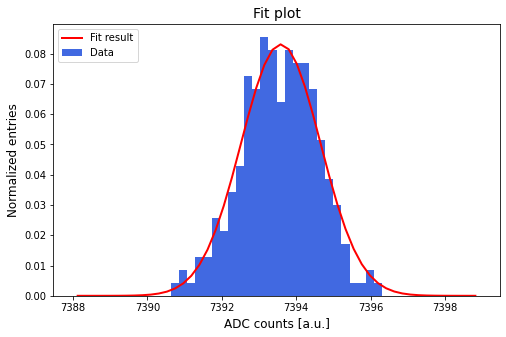

New peak found:
7579
7586
251

----- FIT PLOT -----


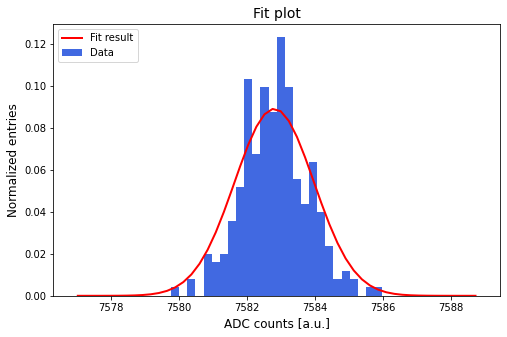

New peak found:
7768
7775
242

----- FIT PLOT -----


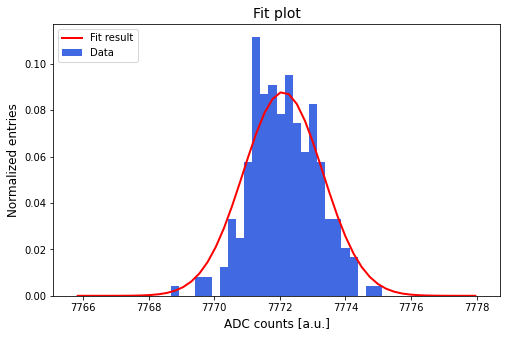

New peak found:
7958
7965
230

----- FIT PLOT -----


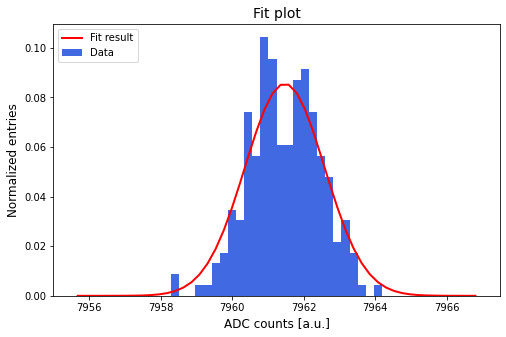

New peak found:
8147
8153
243

----- FIT PLOT -----


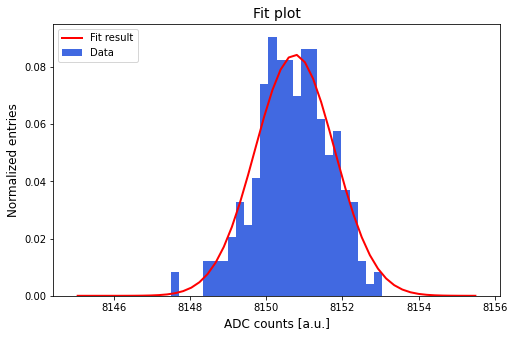

New peak found:
8337
8343
268

----- FIT PLOT -----


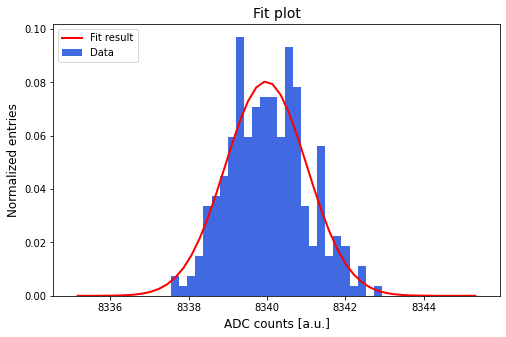

New peak found:
8525
8532
265

----- FIT PLOT -----


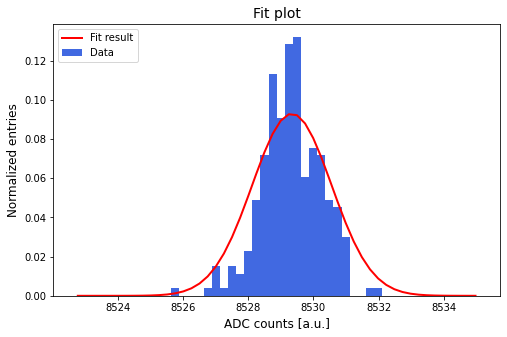

New peak found:
8715
8722
277

----- FIT PLOT -----


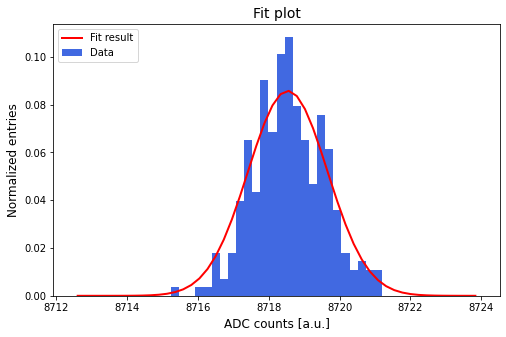

New peak found:
8905
8911
241

----- FIT PLOT -----


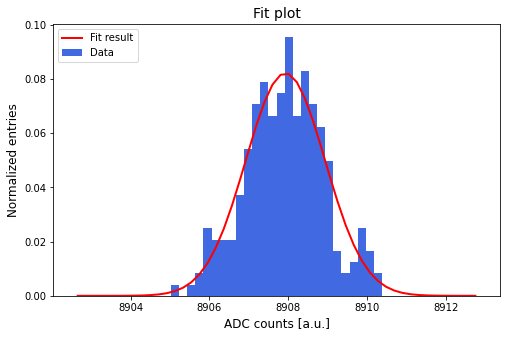

New peak found:
9093
9100
272

----- FIT PLOT -----


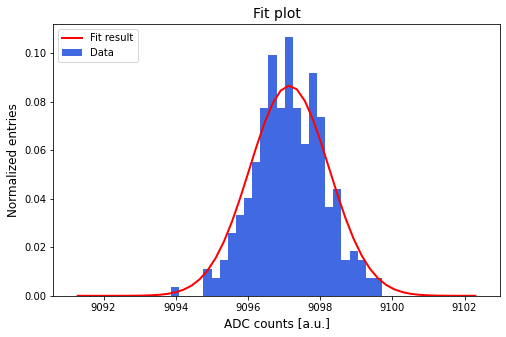

New peak found:
9283
9289
226

----- FIT PLOT -----


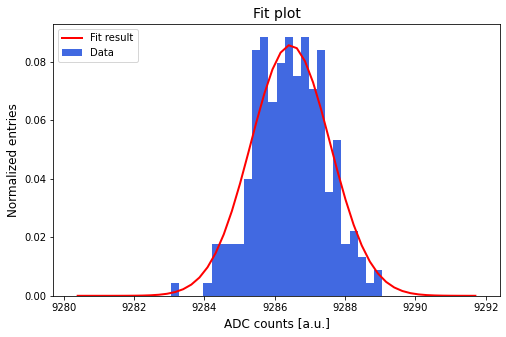

New peak found:
9473
9479
276

----- FIT PLOT -----


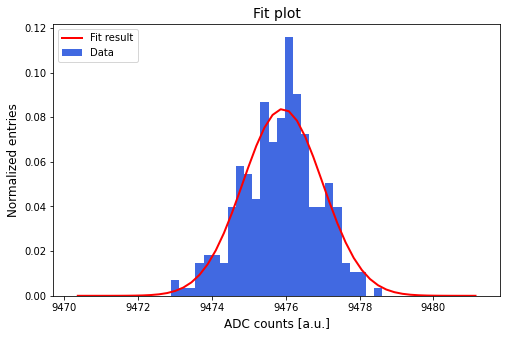

New peak found:
9661
9669
251

----- FIT PLOT -----


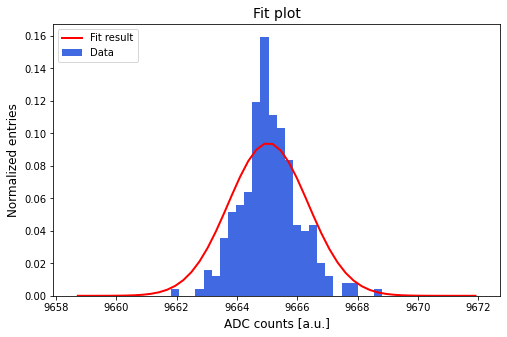

New peak found:
9850
9858
240

----- FIT PLOT -----


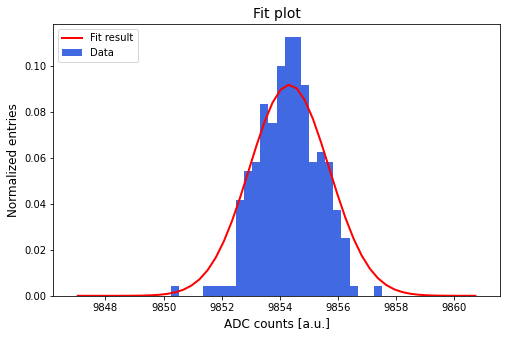

New peak found:
10041
10047
252

----- FIT PLOT -----


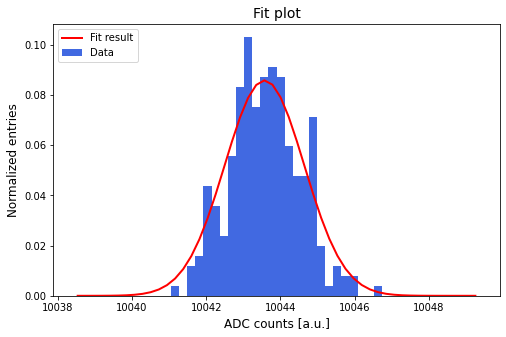

New peak found:
10229
10236
277

----- FIT PLOT -----


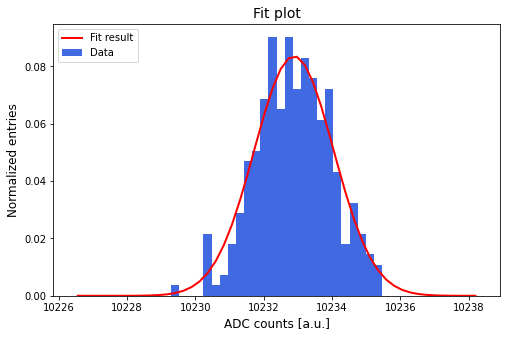

New peak found:
10419
10426
270

----- FIT PLOT -----


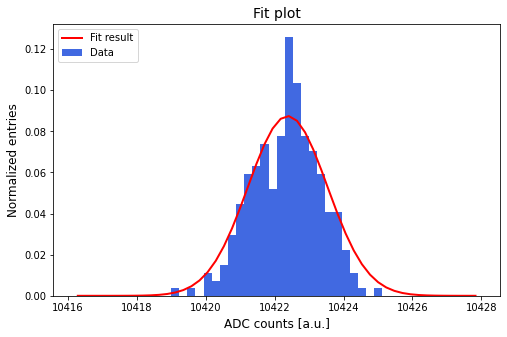

New peak found:
10608
10616
259

----- FIT PLOT -----


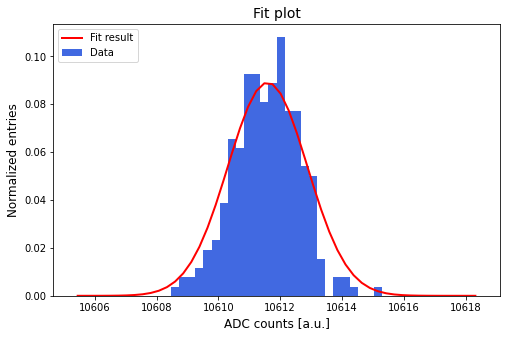

New peak found:
10797
10805
225

----- FIT PLOT -----


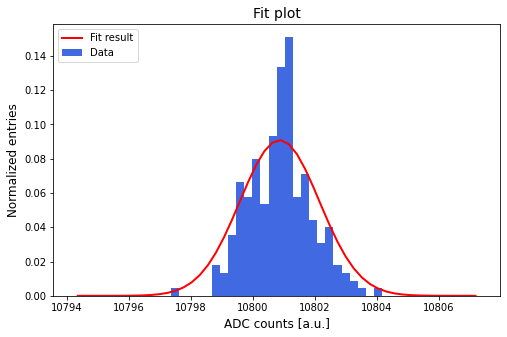

New peak found:
10987
10993
254

----- FIT PLOT -----


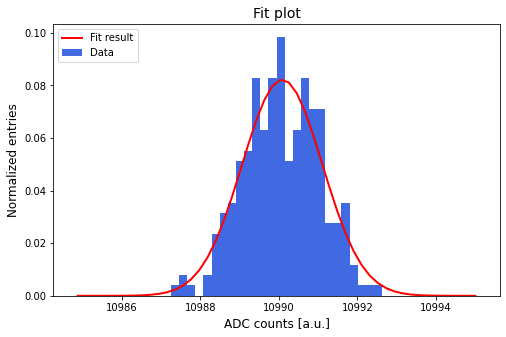

New peak found:
11177
11183
285

----- FIT PLOT -----


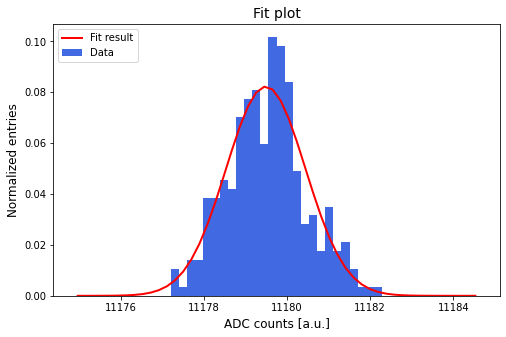

New peak found:
11366
11372
232

----- FIT PLOT -----


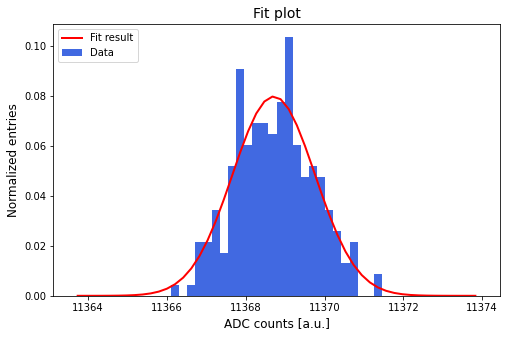

New peak found:
11554
11561
244

----- FIT PLOT -----


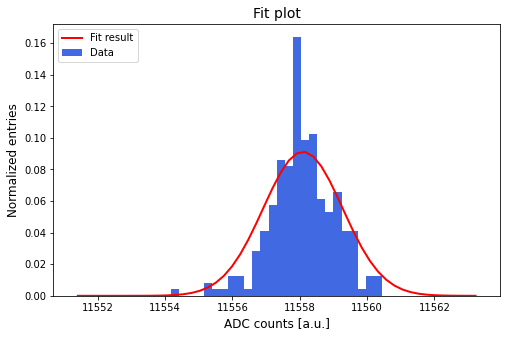

New peak found:
11744
11751
249

----- FIT PLOT -----


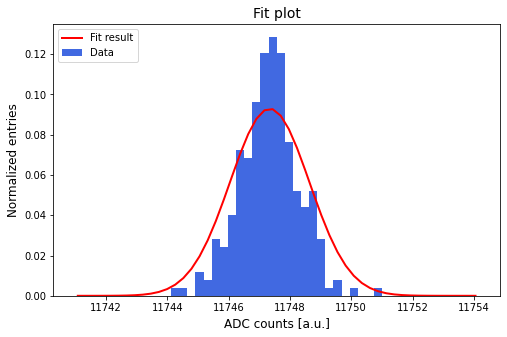

New peak found:
11933
11940
251

----- FIT PLOT -----


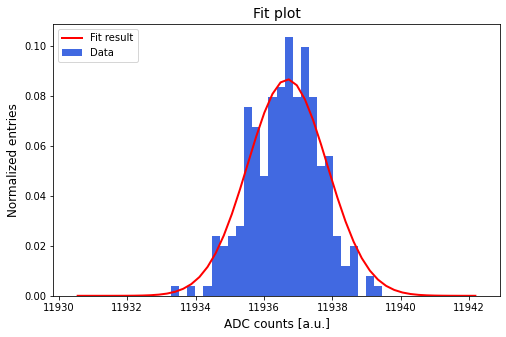

New peak found:
12122
12129
258

----- FIT PLOT -----


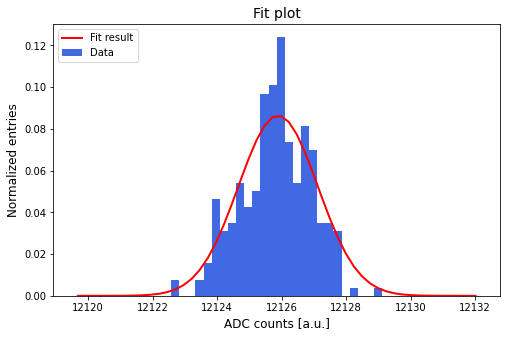

,Times,ADC counts,Uncertainties
0,160.0,200.319284,0.044260
1,320.0,389.709349,0.080032
2,480.0,579.050719,0.037713
3,640.0,768.372617,0.080817
4,800.0,957.685447,0.058221
...,...,...,...
59,9600.0,11368.711710,0.052884
60,9760.0,11558.095275,0.089193
61,9920.0,11747.342503,0.082401
62,10080.0,11936.683491,0.054991


In [35]:
t_mis = list()
errs  = list()

#times = np.linspace (tmin, tmax, len(t_cal))
#print (times)

t_mis, errs = findPeaks(hist, True)

df = pd.DataFrame (np.c_ [t_cal, t_mis, errs], columns = ['Times', 'ADC counts', 'Uncertainties'])
df

A questo punto abbiamo tutto il necessario per procedere con il **fit lineare**!

In [44]:
ones = np.ones_like (t_cal)

X = np.c_ [t_cal, ones]
V = np.diag (np.square (errs))
V_inv = np.linalg.inv (V)

B = np.linalg.inv (X.T @ V_inv @ X) @ X.T @ V_inv
theta = B @ t_mis
U = B @ V @ B.T
print (U) 
sigmas = np.diag(U)
print (sigmas)
sigmas = np.sqrt(sigmas)
print(sigmas)
print ('Results from least square fit:')
print (f'    Slope = {theta[0]:.6f} +/- {sigmas[0]:.6f} a.u./ns')
print (f'    Intercept = {theta[1]:.5f} +/- {sigmas[1]:.5f} a.u.')

[[ 5.38554331e-12 -2.71380053e-08]
 [-2.71380053e-08  1.81014240e-04]]
[5.38554331e-12 1.81014240e-04]
[2.32067734e-06 1.34541533e-02]
Results from least square fit:
    Slope = 1.183083 +/- 0.000002 a.u./ns
    Intercept = 11.12933 +/- 0.01345 a.u.


Verifichiamo la bontà del fit *plottando* i risultati ottenuti!

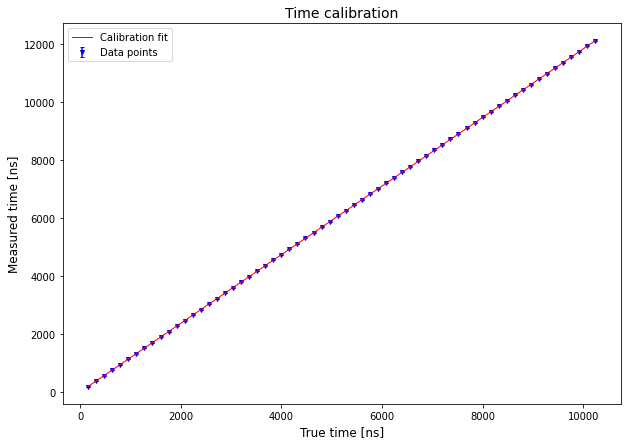

In [29]:
plt.figure (figsize = (10, 7))
plt.title ('Time calibration', fontsize = 14)
plt.xlabel ('True time [ns]', fontsize = 12)
plt.ylabel ('Measured time [ns]', fontsize = 12)

t_fit = theta[0] * t_cal + theta[1]

plt.errorbar (t_cal, t_mis, yerr = errs, color = 'blue', fmt = 'v',
              markersize = 4, barsabove = True, capsize = 2, label = 'Data points')
plt.plot (t_cal, t_fit, color = 'red', linewidth = 1, label = 'Calibration fit')

plt.legend (loc = 'upper left', fontsize = 10)
plt.show()

L'ampia finestra considerata per i tempi non permette di apprezzare eventuali _disaccordi_ con quanto ottenuto dal fit. Per evidenziarli, riportiamo su grafico i cosiddetti **residui**:

<center>$\rm{residuals} = y_{\rm{true}} - y_{\rm{fit}}$</center>

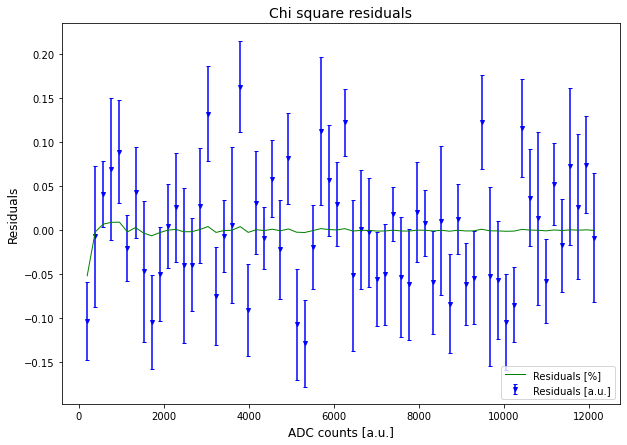

In [30]:
plt.figure (figsize = (10, 7))
plt.title ('Chi square residuals', fontsize = 14)
plt.xlabel ('ADC counts [a.u.]', fontsize = 12)
plt.ylabel ('Residuals', fontsize = 12)

residuals = t_mis - t_fit

plt.errorbar (t_mis, residuals, yerr = errs, color = 'blue', fmt = 'v',
              markersize = 4, barsabove = True, capsize = 2, label = 'Residuals [a.u.]')
plt.plot (t_mis, 100 * residuals / np.array(t_mis), color = 'green', 
          linewidth = 1, label = 'Residuals [%]')

plt.legend (loc = 'lower right', fontsize = 10)
plt.show()

Quindi, sfruttando la libreria `stats` di SciPy, calcoliamo il $\chi^2$ associato al fit:

In [31]:
from scipy.stats import chi2

squares  = np.square (residuals/errs)
chi2_fit = np.sum (squares)
ndf = squares.size - 2
p_val = 1 - chi2.cdf (chi2_fit, ndf)

print ('Results from least square fit:')
print (f'    Slope = {theta[0]:.5f} a.u./ns')
print (f'    Intercept = {theta[1]:.5f} a.u.')
print (f'    chi2 = {chi2_fit:.3f}')
print (f'    ndf  = {ndf:.3f}')
print (f'    p-value = {100*p_val:.1f}%')

Results from least square fit:
    Slope = 1.18308 a.u./ns
    Intercept = 11.12933 a.u.
    chi2 = 100.184
    ndf  = 62.000
    p-value = 0.2%


Infine, siamo in grado di calcolare il **fattore di conversione** da unità arbitrarie a nanosecondi, così come siamo in grado di **correggere** le misure dei tempi per tener conto del contributo sistematico introdotto dalla catena di misura.

In [33]:
conv_factor = 1 / theta[0]
corr_factor = - theta[1] * conv_factor   #errore? 

print ('Results for muon lifetime study:')
print ('    conversion factor = {:.5f} ns/a.u.' . format (conv_factor))
print ('    correction factor = {:.5f} ns' . format (corr_factor))

print ('\nt_corr = ({:.5f}) * t_mis + ({:.5f}) ns' . format (conv_factor, corr_factor))

Results for muon lifetime study:
    conversion factor = 0.84525 ns/a.u.
    correction factor = -9.40706 ns

t_corr = (0.84525) * t_mis + (-9.40706) ns
